# __Air quality prediction on Uganda Dataset__
## __Description__
Until recently there has been a lack of data on air quality across sub-Saharan Africa. Reference grade monitors are extremely expensive and without access to data it is very difficult to raise awareness of the issues, or for government, business and individuals to know which actions to take to improve air quality and protect community health.

AirQo has built a low-cost network of sensors and collected data across 65 locations in Uganda with some sites monitoring for over three years. There is now a wealth of data which can be used to achieve impact in this critical area. Birmingham University’s ASAP project makes use of this and similar data to gain insights into the relationship between urbanisation and air quality.

The increase in availability of air quality data allows us to analyse historical and up to the minute results to gain insights into trends, hotspots, causes and consequences of poor air, potential policy solutions and so much more.

The ability to accurately predict what air quality will be in the coming days is also essential for empowering everyone from governments to families to make informed decisions to protect health and guide action, just as we do with weather.

Activities that are known to contribute to poor air quality such as high traffic volumes, rubbish burning, cooking using charcoal and firewood, even construction or other government works can also be reconsidered depending on the forecast.

If it is known that the next day will be a high pollution day then sports or other events may need to be rescheduled or relocated. Sensitive groups such as children, the elderly, sick or those with respiratory illnesses may need to remain inside. Schools can plan the timing of outdoor activities such as field trips or sports events with confidence.

We are hopeful that these forecasts will be used to inform public awareness and be built into safety alerts. They can become part of daily news coverage whether in traditional or social media in the same way weather is currently presented. The solution could literally be life saving.

The objective of this challenge is to accurately forecast air quality (as measured by PM2.5 µ/m3) for each hour of the coming 25 hours across five locations in Kampala Uganda. Forecasts will be based on the past 5 days of hourly air quality measurements at each site.

The used data is from a challenge on Zindi, a data science competition platform with the mission of building the data science ecosystem in Africa: [more details](https://zindi.africa/competitions/airqo-ugandan-air-quality-forecast-challenge)

---

## __Stakeholder__
Uganda Broadcasting Corporation (acronym: UBC) is the public broadcaster network in Uganda, located in Uganda's capital Kampala. 

UBC wants to expand their weather forecast and include the air pollution for each hour of the coming 25 hours across five locations in Kampala. The population should be warned by high pollution and the health concern to act accordingly.

---

## __Data__
The weather indicators available in the train and test are:

* temp: mean temperature recorded at the site over the hour (in degrees Celsius)
* precip: precip for precipitation, precip is here used for total rainfall in mm recorded at the site over the hour (in mm)
* rel_humidity: mean relative humidity recorded over the hour (in %)
* wind_dir: mean direction of the wind over the hour (in °N))
* wind_spd: mean wind speed at the site over the hour (in metres per second)
* atmos_press: mean atmospheric pressure(in atm)


Each series of weather and air quality readings will be associated with a unique sensor. Each of the five sensors (named A-E) will have a set of features which we excluded in our forecast:

* meta data by location: one of either A,B,C, D or E referring to the five different locations selected
    * location details 
    * distance to motorways and roads
    * waste incineration and fuels in private kitchens (firewood, coal)


---

## __Importing packages and tools__

In [1]:
# import packages
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math
from math import sqrt
import gc

import metpy.calc as mpcalc
from metpy.units import units

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

import itertools

from yellowbrick.regressor import ResidualsPlot

---

## __Load the data and get an overview__

The data on Zindi was splitted in train and test data csv files.

We loaded the train data csv and got a first overview of the data itself.

In [2]:
# load data
train=pd.read_csv("../data/Train.csv")
sample_sub=pd.read_csv("../data/sample_sub.csv")

In [3]:
train.head()

,ID,location,temp,precip,rel_humidity,wind_dir,wind_spd,atmos_press,target
0,ID_train_0,C,"nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...",45.126304
1,ID_train_1,D,"22.53333333,21.71666667,20.83333333,20.9833333...","0.102,0.0,0.0,0.0,0.0,0.0,0.0,0.034,0.017,0.01...","0.744583333,0.808083333,0.911166667,0.91633333...","281.6643101,89.15629262,81.96853891,291.018632...","2.3775,1.126666667,0.700833333,0.3416666670000...","90.32,90.3775,90.44083333,90.4725,90.45416667,...",79.131702
2,ID_train_10,A,"28.975,27.95,29.6,26.425,22.09166667,21.775,22...","0.0,0.0,0.0,0.102,0.136,0.0,0.0,2.16,1.276,0.0...","0.573333333,0.597166667,0.5668333329999999,0.6...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","88.55166667,88.46416667,88.31916667,88.24,88.2...",32.661304
3,ID_train_100,A,"22.96666667,24.26666667,25.275,25.625,25.86666...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.77,3.012,1.0...","0.8430833329999999,0.79025,0.7375,0.728,0.7049...","300.0850574,293.6769595,294.5174647,301.921416...","1.446666667,1.1925,1.324166667,1.5441666669999...","88.615,88.53083333,88.4,88.27166667,88.2075,88...",53.850238
4,ID_train_1000,A,"21.875,21.575,21.525,21.43333333,20.50833333,1...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.8564166670000001,0.874916667,0.879833333,0.8...","21.83997432,17.05405341,89.26406044,123.585424...","0.1975,0.244166667,0.411666667,0.56,0.5775,0.4...","88.55666667,88.64083333,88.65833333,88.6475,88...",177.418750


---

## __Organizing the data__

As we can see, for each ID we have a time series for all weather data. 

So we have 9 columns at the beginning: 6 features and 3 columns in total for location, ID and target (measured particulate matter (PM))


We need to transform the time series into columns to use them in our model.

After converting the features from string to a list of values, we wanted to get an overview of the train data again. 
As you can see there were a lot of nan, so we needed to remove them.

In the following step we splitted the time series and created an iterating FOR loop to convert them into columns for each feature: 120 in total for each hour of the 5 days and 1 additional hour for the starting hour of the measurement (marked as 0). 
We dropped then the former feature columns and only used the 121 new columns (for each feature) for the train data.
So we are able to use the data in a model now.

In [4]:
# convert features from string to List of values 
def replace_nan(x):
    if x==" ":
        return np.nan
    else :
        return float(x)
features=["temp","precip","rel_humidity","wind_dir","wind_spd","atmos_press"]
for feature in features : 
    train[feature]=train[feature].apply(lambda x: [ replace_nan(X) for X in x.replace("nan"," ").split(",")])

In [5]:
train.head()

,ID,location,temp,precip,rel_humidity,wind_dir,wind_spd,atmos_press,target
0,ID_train_0,C,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",45.126304
1,ID_train_1,D,"[22.53333333, 21.71666667, 20.83333333, 20.983...","[0.102, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.034, 0...","[0.744583333, 0.808083333, 0.911166667, 0.9163...","[281.6643101, 89.15629262, 81.96853891, 291.01...","[2.3775, 1.126666667, 0.700833333, 0.341666667...","[90.32, 90.3775, 90.44083333, 90.4725, 90.4541...",79.131702
2,ID_train_10,A,"[28.975, 27.95, 29.6, 26.425, 22.09166667, 21....","[0.0, 0.0, 0.0, 0.102, 0.136, 0.0, 0.0, 2.16, ...","[0.573333333, 0.597166667, 0.5668333329999999,...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[88.55166667, 88.46416667, 88.31916667, 88.24,...",32.661304
3,ID_train_100,A,"[22.96666667, 24.26666667, 25.275, 25.625, 25....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.77,...","[0.8430833329999999, 0.79025, 0.7375, 0.728, 0...","[300.0850574, 293.6769595, 294.5174647, 301.92...","[1.446666667, 1.1925, 1.324166667, 1.544166666...","[88.615, 88.53083333, 88.4, 88.27166667, 88.20...",53.850238
4,ID_train_1000,A,"[21.875, 21.575, 21.525, 21.43333333, 20.50833...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.8564166670000001, 0.874916667, 0.879833333,...","[21.83997432, 17.05405341, 89.26406044, 123.58...","[0.1975, 0.244166667, 0.411666667, 0.56, 0.577...","[88.55666667, 88.64083333, 88.65833333, 88.647...",177.418750


In [6]:
#remove the nan in the cells

def remove_nan_values(x):
    return [e for e in x if not math.isnan(e)]

In [7]:
#tqdm allows us to output a smart progress bar by wrapping around any iterable
#tqdm shows how much time elapsed and the estimated time remaining for the iterable

for col_name in tqdm(features):
    train[col_name]=train[col_name].apply(remove_nan_values)

100%|██████████| 6/6 [00:01<00:00,  3.46it/s]


In [8]:
#get an overview after removing the nan values

train.head()

,ID,location,temp,precip,rel_humidity,wind_dir,wind_spd,atmos_press,target
0,ID_train_0,C,"[26.90909091, 27.20833333, 26.18333333, 24.7, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.5108181820000001, 0.535416667, 0.6145, 0.63...","[272.90275160000004, 104.565241, 167.1772247, ...","[0.800909091, 1.073333333, 1.5175, 1.4625, 0.5...","[87.77727273, 87.6525, 87.61416667, 87.6375, 8...",45.126304
1,ID_train_1,D,"[22.53333333, 21.71666667, 20.83333333, 20.983...","[0.102, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.034, 0...","[0.744583333, 0.808083333, 0.911166667, 0.9163...","[281.6643101, 89.15629262, 81.96853891, 291.01...","[2.3775, 1.126666667, 0.700833333, 0.341666667...","[90.32, 90.3775, 90.44083333, 90.4725, 90.4541...",79.131702
2,ID_train_10,A,"[28.975, 27.95, 29.6, 26.425, 22.09166667, 21....","[0.0, 0.0, 0.0, 0.102, 0.136, 0.0, 0.0, 2.16, ...","[0.573333333, 0.597166667, 0.5668333329999999,...","[328.68291380000005, 307.8251459, 319.0177512,...","[1.0325, 1.193333333, 1.275833333, 1.493333333...","[88.55166667, 88.46416667, 88.31916667, 88.24,...",32.661304
3,ID_train_100,A,"[22.96666667, 24.26666667, 25.275, 25.625, 25....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.77,...","[0.8430833329999999, 0.79025, 0.7375, 0.728, 0...","[300.0850574, 293.6769595, 294.5174647, 301.92...","[1.446666667, 1.1925, 1.324166667, 1.544166666...","[88.615, 88.53083333, 88.4, 88.27166667, 88.20...",53.850238
4,ID_train_1000,A,"[21.875, 21.575, 21.525, 21.43333333, 20.50833...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.8564166670000001, 0.874916667, 0.879833333,...","[21.83997432, 17.05405341, 89.26406044, 123.58...","[0.1975, 0.244166667, 0.411666667, 0.56, 0.577...","[88.55666667, 88.64083333, 88.65833333, 88.647...",177.418750


In [9]:
#splitted the timeseries in the columns and created new columns for each one of the hours (5 days) and 1 additional column as the start time, 
#so 121 new columns in total for each feature

for x in range(121):
    train["newtemp"+ str(x)] = train.temp.str[x]
    train["newprecip"+ str(x)] = train.precip.str[x]
    train["newrel_humidity"+ str(x)] = train.rel_humidity.str[x]
    train["newwind_dir"+ str(x)] = train.wind_dir.str[x]
    train["windspeed"+ str(x)] = train.wind_spd.str[x]
    train["atmospherepressure"+ str(x)] = train.atmos_press.str[x]

/var/folders/c1/zn6b0wrn01j8zm4w926xwn6h0000gn/T/ipykernel_1806/1416853421.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  train["newrel_humidity"+ str(x)] = train.rel_humidity.str[x]
/var/folders/c1/zn6b0wrn01j8zm4w926xwn6h0000gn/T/ipykernel_1806/1416853421.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  train["newwind_dir"+ str(x)] = train.wind_dir.str[x]
/var/folders/c1/zn6b0wrn01j8zm4w926xwn6h0000gn/T/ipykernel_1806/1416853421.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of 

In [10]:
#drop the originally 6 feature columns and only left the new ones with the added number for each hour

train.drop(features,1,inplace=True)

/var/folders/c1/zn6b0wrn01j8zm4w926xwn6h0000gn/T/ipykernel_1806/676256044.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  train.drop(features,1,inplace=True)


In [11]:
#get an overview of the updated columns

train.head()

,ID,location,target,newtemp0,newprecip0,newrel_humidity0,newwind_dir0,windspeed0,atmospherepressure0,newtemp1,...,newrel_humidity119,newwind_dir119,windspeed119,atmospherepressure119,newtemp120,newprecip120,newrel_humidity120,newwind_dir120,windspeed120,atmospherepressure120
0,ID_train_0,C,45.126304,26.909091,0.000,0.510818,272.902752,0.800909,87.777273,27.208333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ID_train_1,D,79.131702,22.533333,0.102,0.744583,281.664310,2.377500,90.320000,21.716667,...,0.649250,73.528733,1.475833,90.439167,21.450000,0.561,0.797333,296.967254,1.019167,90.529167
2,ID_train_10,A,32.661304,28.975000,0.000,0.573333,328.682914,1.032500,88.551667,27.950000,...,0.437917,NaN,NaN,88.415833,NaN,NaN,NaN,NaN,NaN,NaN
3,ID_train_100,A,53.850238,22.966667,0.000,0.843083,300.085057,1.446667,88.615000,24.266667,...,0.766417,NaN,NaN,88.490833,24.641667,0.000,0.719667,NaN,NaN,88.465833
4,ID_train_1000,A,177.418750,21.875000,0.000,0.856417,21.839974,0.197500,88.556667,21.575000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now the time series where split into columns and can be used in a model.

As we can see we have a lot of Nan Values that have to be dealt with.

---

## __Dealing with Nan__

In all weather data the Nans have to be dealt with differently. To fill all with the same number is not suitable.

To get an idea about the number of nan we used regex as a filter for "temp".

In [12]:
np.array(train.filter(regex='temp', axis = 1).iloc[4:5, :])

array([[21.875     , 21.575     , 21.525     , 21.43333333, 20.50833333,
        19.91666667, 18.99166667, 18.59166667, 18.05      , 17.91666667,
        18.16666667, 17.525     , 19.19166667, 22.45833333, 25.01666667,
        25.85833333, 26.85      , 27.625     , 28.35833333, 28.75      ,
        27.85      , 23.76666667, 20.89166667, 21.00833333, 20.60833333,
        20.19166667, 20.10833333, 19.63333333, 21.26363636, 20.61666667,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,     

As we can see in this example, most of the time the time series stopped completely and Nans are rare in the middle of the series.

Since our goal is to predict air pollution for the next day, we can not predict the PM2.5 safely, when most data is missing. 

We assume that the biggest influence on the predicted target value are the values of the last day. 
Therefore we will exclude all rows where 121 * 0.2 = 24.2, so one day of data is missing.

We will calculate the percentage of the Nan to see how much data is missing by each feature.

In [13]:
# calculating the percentage of Nan Values per time series for each weather data
nanperrow_precip = train.filter(regex='precip', axis = 1).isnull().sum(axis = 1)/121
nanperrow_temp = train.filter(regex='temp', axis = 1).isnull().sum(axis = 1)/121
nanperrow_windspeed = train.filter(regex='windspeed', axis = 1).isnull().sum(axis = 1)/121
nanperrow_wind_dir = train.filter(regex='wind_dir', axis = 1).isnull().sum(axis = 1)/121
nanperrow_rel_humidity = train.filter(regex='rel_humidity', axis = 1).isnull().sum(axis = 1)/121
nanperrow_atmospherepressure = train.filter(regex='atmospherepressure', axis = 1).isnull().sum(axis = 1)/121

In [14]:
matrix_nan = pd.concat([nanperrow_precip, nanperrow_temp, nanperrow_windspeed, nanperrow_wind_dir, nanperrow_rel_humidity, nanperrow_atmospherepressure]
        ,keys = ['precip', 'temp', 'windspeed', 'wind_dir', 'rel_humidity', 'atmospherepressure'], axis = 1)
matrix_nan.head()

,precip,temp,windspeed,wind_dir,rel_humidity,atmospherepressure
0,0.867769,0.867769,0.867769,0.867769,0.867769,0.867769
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.008264,0.008264,0.380165,0.380165,0.008264,0.008264
3,0.000000,0.000000,0.421488,0.421488,0.000000,0.000000
4,0.752066,0.752066,0.752066,0.752066,0.752066,0.752066


Here we can see that either the complete station stopped working or only certain data is missing.

In [15]:
train = train[matrix_nan.max(axis=1) <= 0.2]
print(train.shape)
train.head()

(12909, 729)


,ID,location,target,newtemp0,newprecip0,newrel_humidity0,newwind_dir0,windspeed0,atmospherepressure0,newtemp1,...,newrel_humidity119,newwind_dir119,windspeed119,atmospherepressure119,newtemp120,newprecip120,newrel_humidity120,newwind_dir120,windspeed120,atmospherepressure120
1,ID_train_1,D,79.131702,22.533333,0.102,0.744583,281.664310,2.377500,90.320000,21.716667,...,0.649250,73.528733,1.475833,90.439167,21.450000,0.561,0.797333,296.967254,1.019167,90.529167
5,ID_train_10000,E,17.005000,26.225000,0.000,0.756667,104.373721,1.485833,88.565833,26.250000,...,0.900083,NaN,NaN,88.525000,25.075000,0.000,0.773000,NaN,NaN,88.510000
6,ID_train_10001,C,53.100000,21.866667,0.000,0.548333,334.082716,1.152500,87.736667,21.383333,...,0.996667,157.853489,0.684167,87.686667,19.508333,0.868,0.995833,207.023076,0.633333,87.663333
7,ID_train_10002,A,55.051143,28.241667,0.000,0.527250,328.461619,1.926667,88.014167,27.900000,...,0.997583,NaN,NaN,88.181667,18.975000,0.000,0.998500,NaN,NaN,88.175833
10,ID_train_10005,D,55.638261,19.400000,0.000,0.927500,30.343767,0.348333,90.788333,18.991667,...,0.759167,NaN,NaN,90.555833,20.491667,0.000,NaN,NaN,NaN,90.531667


Now we still have missing values in the cases were less than one day of data was missing. In these cases, we want to replace the missing values with the median of our time series. 

We are aware that this is not a perfect solution since most aspects are time dependent (e.g temperature is lower at nights). A better solution would be to replace them with the average values of the same time point of the last days. Due to time concerns in this project we will replace them with the median.

In [16]:
nanperrow_precip = train.filter(regex='precip', axis = 1)
nanperrow_temp = train.filter(regex='temp', axis = 1)
nanperrow_windspeed = train.filter(regex='windspeed', axis = 1)
nanperrow_wind_dir = train.filter(regex='wind_dir', axis = 1)
nanperrow_rel_humidity = train.filter(regex='rel_humidity', axis = 1)
nanperrow_atmospherepressure = train.filter(regex='atmospherepressure', axis = 1)
nanperrow_wind_dir.head()

,newwind_dir0,newwind_dir1,newwind_dir2,newwind_dir3,newwind_dir4,newwind_dir5,newwind_dir6,newwind_dir7,newwind_dir8,newwind_dir9,...,newwind_dir111,newwind_dir112,newwind_dir113,newwind_dir114,newwind_dir115,newwind_dir116,newwind_dir117,newwind_dir118,newwind_dir119,newwind_dir120
1,281.664310,89.156293,81.968539,291.018632,279.391524,158.026892,248.316596,211.143363,315.319213,307.355471,...,95.579420,46.389978,112.100827,97.603374,69.085542,171.660338,183.291765,213.937567,73.528733,296.967254
5,104.373721,161.285129,161.322434,142.997967,175.217836,159.151863,163.667428,165.999365,174.833334,190.005342,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,334.082716,332.403760,328.582905,332.170042,335.250267,335.083040,332.168131,335.505645,330.749248,329.591838,...,163.192418,164.416925,169.332829,174.026301,170.413145,173.835869,172.414007,160.207851,157.853489,207.023076
7,328.461619,336.579037,346.575395,18.861208,15.121389,275.571631,45.220647,353.989693,315.103338,339.796199,...,223.254622,178.491268,193.301619,220.905967,229.398735,251.739098,NaN,NaN,NaN,NaN
10,30.343767,10.479259,316.712671,295.147569,337.774172,219.252668,2.746794,184.879296,141.397587,130.539041,...,60.329112,34.933852,22.195204,20.413948,23.500409,11.659831,89.348356,133.173511,NaN,NaN


In [17]:
nanperrow_precip = nanperrow_precip.apply(lambda x: x.fillna(x.median()),axis=1)
nanperrow_temp = nanperrow_temp.apply(lambda x: x.fillna(x.median()),axis=1)
nanperrow_windspeed = nanperrow_windspeed.apply(lambda x: x.fillna(x.median()),axis=1)
nanperrow_wind_dir = nanperrow_wind_dir.apply(lambda x: x.fillna(x.median()),axis=1)
nanperrow_rel_humidity = nanperrow_rel_humidity.apply(lambda x: x.fillna(x.median()),axis=1)
nanperrow_atmospherepressure = nanperrow_atmospherepressure.apply(lambda x: x.fillna(x.median()),axis=1)
nanperrow_wind_dir.head()

,newwind_dir0,newwind_dir1,newwind_dir2,newwind_dir3,newwind_dir4,newwind_dir5,newwind_dir6,newwind_dir7,newwind_dir8,newwind_dir9,...,newwind_dir111,newwind_dir112,newwind_dir113,newwind_dir114,newwind_dir115,newwind_dir116,newwind_dir117,newwind_dir118,newwind_dir119,newwind_dir120
1,281.664310,89.156293,81.968539,291.018632,279.391524,158.026892,248.316596,211.143363,315.319213,307.355471,...,95.579420,46.389978,112.100827,97.603374,69.085542,171.660338,183.291765,213.937567,73.528733,296.967254
5,104.373721,161.285129,161.322434,142.997967,175.217836,159.151863,163.667428,165.999365,174.833334,190.005342,...,164.615326,164.615326,164.615326,164.615326,164.615326,164.615326,164.615326,164.615326,164.615326,164.615326
6,334.082716,332.403760,328.582905,332.170042,335.250267,335.083040,332.168131,335.505645,330.749248,329.591838,...,163.192418,164.416925,169.332829,174.026301,170.413145,173.835869,172.414007,160.207851,157.853489,207.023076
7,328.461619,336.579037,346.575395,18.861208,15.121389,275.571631,45.220647,353.989693,315.103338,339.796199,...,223.254622,178.491268,193.301619,220.905967,229.398735,251.739098,263.736010,263.736010,263.736010,263.736010
10,30.343767,10.479259,316.712671,295.147569,337.774172,219.252668,2.746794,184.879296,141.397587,130.539041,...,60.329112,34.933852,22.195204,20.413948,23.500409,11.659831,89.348356,133.173511,114.223616,114.223616


As you can see, the median is now included and replaced the Nan values e.g. for line 5.

In the next step we concatenated the current table with the three columns ID, target and location.
We checked then again the updated dataset for null values.


In [18]:
data = pd.concat([train[['ID', 'target', 'location']], nanperrow_precip, nanperrow_temp, nanperrow_windspeed,
                nanperrow_wind_dir, nanperrow_rel_humidity, nanperrow_atmospherepressure], axis = 1)
data.head()

,ID,target,location,newprecip0,newprecip1,newprecip2,newprecip3,newprecip4,newprecip5,newprecip6,...,atmospherepressure111,atmospherepressure112,atmospherepressure113,atmospherepressure114,atmospherepressure115,atmospherepressure116,atmospherepressure117,atmospherepressure118,atmospherepressure119,atmospherepressure120
1,ID_train_1,79.131702,D,0.102,0.0,0.0,0.0,0.0,0.0,0.0,...,90.707500,90.682500,90.604167,90.481667,90.354167,90.272500,90.266667,90.325833,90.439167,90.529167
5,ID_train_10000,17.005000,E,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,88.418333,88.380833,88.337500,88.341667,88.331667,88.354167,88.420000,88.500833,88.525000,88.510000
6,ID_train_10001,53.100000,C,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,87.522500,87.560833,87.580000,87.626667,87.672500,87.686667,87.680000,87.733333,87.686667,87.663333
7,ID_train_10002,55.051143,A,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,88.390833,88.431667,88.448333,88.432500,88.363333,88.282500,88.276667,88.243333,88.181667,88.175833
10,ID_train_10005,55.638261,D,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,90.221667,90.211667,90.221667,90.255833,90.367500,90.475000,90.548333,90.564167,90.555833,90.531667


In [19]:
data.isnull().sum().sum()

0

As we can see we have zero missing values as a result in our data.

---

## __Visualization of time series__

Let's have a look on an example dataset and visualize the meteorological parameters. We again used the filter with regex.

We decided then to plot the features. Temperature and relative humidity as well as wind speed and wind direction were plotted together in one plot.

In [20]:
data_temp=np.array(data.filter(regex='newtemp', axis=1).loc[[5660]])[0]
data_humid=np.array(data.filter(regex='newrel_humidity', axis=1).loc[[5660]])[0]
data_humid = data_humid*100
data_precip=np.array(data.filter(regex='newprecip', axis=1).loc[[5660]])[0]
data_windsp=np.array(data.filter(regex='windspeed', axis=1).loc[[5660]])[0]
data_winddir=np.array(data.filter(regex='newwind_dir', axis=1).loc[[5660]])[0]
data_atmos=np.array(data.filter(regex='atmospherepressure', axis=1).loc[[5660]])[0]

### __Temperature and humidity__

Temperature (in degrees Celsius) is shown in red. The daily peaks can be seen, but there are also influencing factors, like it is visible around time step 40. 

The relative humidity (in %) is shown in blue. Relative humidity is depending on the temperature, what becomes obvious in the plot. For the modelling a temperature independent measure for humidity might be useful (see __Feature Engineering__).

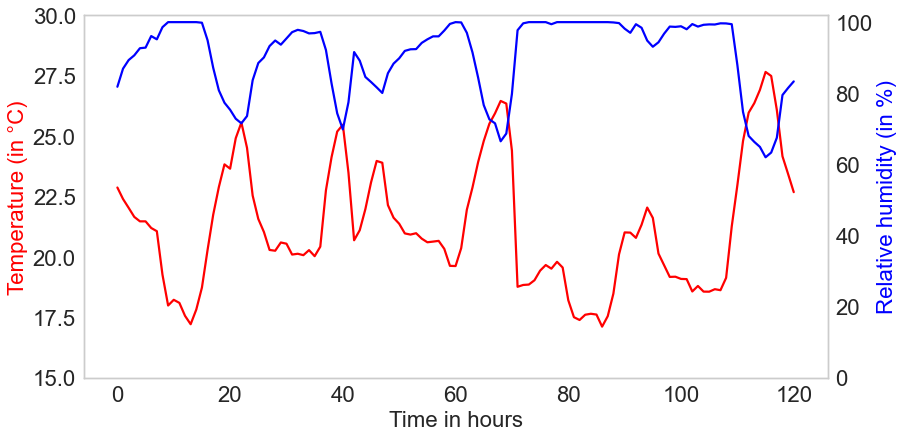

In [21]:
fig=plt.figure(figsize=(12, 6), dpi=80)
plt.plot(data_temp, color="red",linewidth=2)
plt.xlabel("Time in hours", fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel("Temperature (in °C)", color="red", fontsize=20)
plt.yticks(np.arange(15,31,2.5),fontsize=20)
plt.grid(False)

ax=fig.add_subplot
ax2=plt.twinx()
ax2.plot(data_humid,color="blue",linewidth=2) 
ax2.set_ylabel("Relative humidity (in %)",color="blue",fontsize=20)
plt.yticks(np.arange(0,101,20),fontsize=20)
plt.grid(False)
plt.show()

### __Precipitation__

For precipitation, we only see few peaks. Comparing to the temperature, precipitation shows a cooling effect, but also leads to increased humidity after the rainfall. Higher humidity makes the particles more heavy and tends to push them downwards, only with continuing precipitation the particles would be washed out.

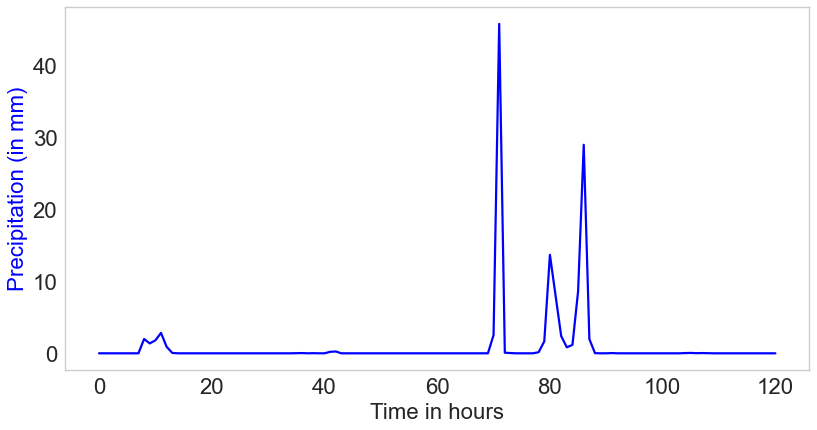

In [22]:
plt.figure(figsize=(12, 6), dpi=80)
sns.lineplot(x=range(121), y=data_precip, color='blue',linewidth=2)
plt.xlabel('Time in hours', fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('Precipitation (in mm)', fontsize=20, color='blue')
plt.yticks(fontsize=20)
plt.grid(False)
plt.show()


### __Wind__

Information on wind are given as wind speed (in m/s) and wind direction (in °N). In this example the wind speed decreases during the same time period were we could detect the high humidity, this means there is no mixture of the atmosphere and the particles are not blown away. We also have information of the wind direction, which could have an influence, for example if the wind is blowing from an industrial facility. For modelling we will convert wind speed and direction to North-South- and East-West-component in order to avoid the similarity of 0° and 360° (see __Feature Engineering__).

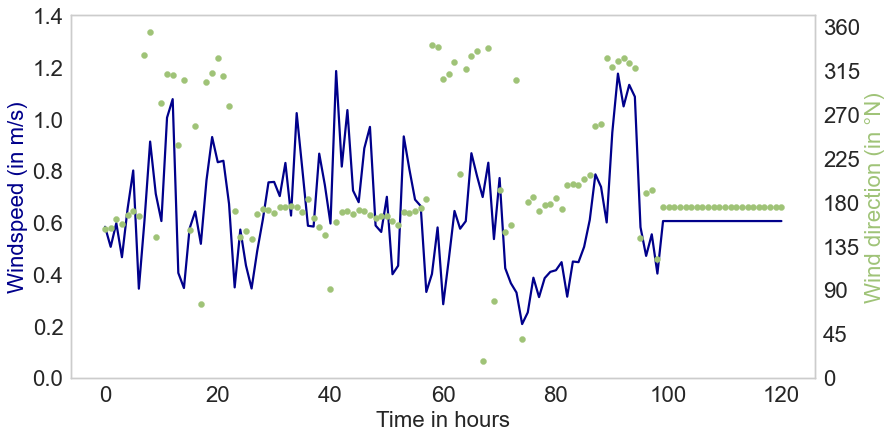

In [23]:
fig=plt.figure(figsize=(12, 6), dpi=80)
plt.plot(data_windsp, color="darkblue",linewidth=2)
plt.xlabel("Time in hours", fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel("Windspeed (in m/s)", color="darkblue", fontsize=20)
plt.yticks(np.arange(0,1.6,0.2),fontsize=20)
plt.grid(False)

ax=fig.add_subplot
ax2=plt.twinx()
ax2.scatter(x=range(121), y=data_winddir,color="g",s=30) 
ax2.set_ylabel("Wind direction (in °N)",color="g",fontsize=20)
plt.yticks(np.arange(0,361,45),fontsize=20)
plt.grid(False)
plt.show()

### __Atmospheric pressure__

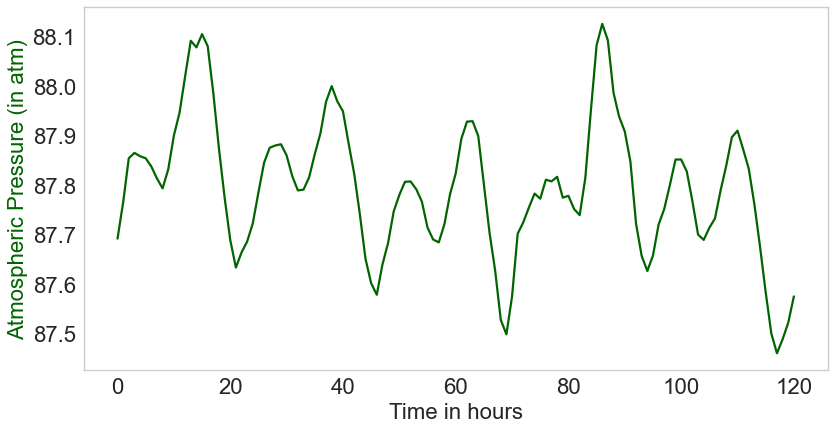

In [24]:
plt.figure(figsize=(12, 6), dpi=80)
sns.lineplot(x=range(121), y=data_atmos, color='darkgreen',linewidth=2)
plt.xlabel('Time in hours', fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('Atmospheric Pressure (in atm)', fontsize=20, color='darkgreen')
plt.yticks(fontsize=20)
plt.grid(False)
plt.show()

---

## __EDA__

EDA on time series is very difficult to interpret. Therefore the EDA will be performed on an aggregated dataset.

After enumerating through a for loop to add median, minimum, maximum and sum to each feature, we wanted to get an overview of the dataset.
We grouped by each location by the median of the target and used a box plot to see the differences and the impact of the location.
In the next step we used a pair plot and a heatmap to identify correlations.

In [25]:
data_agg = data[['target', 'location']]
data_agg.head()

,target,location
1,79.131702,D
5,17.005000,E
6,53.100000,C
7,55.051143,A
10,55.638261,D


In [26]:
#for loop to add median, minimum, maximum and sum after each of the features

names = ['precip', 'temp', 'windspeed', 'wind_dir', 'rel_humid', 'atmos']
for i, value in enumerate([nanperrow_precip, nanperrow_temp, nanperrow_windspeed, nanperrow_wind_dir, nanperrow_rel_humidity
    , nanperrow_atmospherepressure]):
    median = value.median(axis = 1)
    mind = value.min(axis = 1)
    maxi = value.max(axis = 1)
    summ = value.sum(axis = 1)
    data_agg = pd.concat([data_agg, pd.DataFrame(median, columns = ['median']), 
                                    pd.DataFrame(mind, columns = ['min']), 
                                    pd.DataFrame(maxi, columns = ['max']),
                                    pd.DataFrame(summ, columns = ['sum'])], 
                                    axis = 1)

In [27]:
counter = 0
counter2 = 0.25
names = ['dummy','precip', 'temp', 'windspeed', 'wind_dir', 'rel_humid', 'atmos']
liste = []
for i in list(data_agg.columns):
    if counter < 2:
        liste.append(i)
        counter += 1
    else:
        liste.append(names[math.ceil(counter2)]+ '_' + i)
        counter += 1
        counter2 += 0.25
#print(liste)
data_agg = data_agg.set_axis(liste, axis = 1)
data_agg.head()

,target,location,precip_median,precip_min,precip_max,precip_sum,temp_median,temp_min,temp_max,temp_sum,...,wind_dir_max,wind_dir_sum,rel_humid_median,rel_humid_min,rel_humid_max,rel_humid_sum,atmos_median,atmos_min,atmos_max,atmos_sum
1,79.131702,D,0.0,0.0,0.561,0.850,23.791667,17.983333,33.616667,2986.166667,...,357.730286,21430.292415,0.791000,0.403083,0.979250,91.725000,90.429167,90.056667,90.725000,10942.020833
5,17.005000,E,0.0,0.0,22.898,69.301,22.316667,17.183333,28.416667,2732.415909,...,353.098975,20301.270090,0.804333,0.598083,0.997750,96.198705,88.420833,88.097500,88.746667,10700.955000
6,53.100000,C,0.0,0.0,2.076,6.973,22.925000,19.116667,29.266667,2860.250000,...,339.167183,25209.529711,0.751667,0.410000,0.996667,87.778333,87.729167,87.472500,87.961667,10613.835000
7,55.051143,A,0.0,0.0,31.842,76.740,22.075000,16.933333,29.483333,2737.566667,...,359.301348,27390.802946,0.841333,0.513750,0.999667,97.743758,88.235000,87.838333,88.511667,10673.730833
10,55.638261,D,0.0,0.0,10.302,11.476,22.033333,17.191667,34.041667,2805.930303,...,358.576390,18990.034820,0.844167,0.385000,0.985833,95.567500,90.641667,90.211667,90.986667,10965.602500


In [28]:
data_agg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12909 entries, 1 to 15538
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   target            12909 non-null  float64
 1   location          12909 non-null  object 
 2   precip_median     12909 non-null  float64
 3   precip_min        12909 non-null  float64
 4   precip_max        12909 non-null  float64
 5   precip_sum        12909 non-null  float64
 6   temp_median       12909 non-null  float64
 7   temp_min          12909 non-null  float64
 8   temp_max          12909 non-null  float64
 9   temp_sum          12909 non-null  float64
 10  windspeed_median  12909 non-null  float64
 11  windspeed_min     12909 non-null  float64
 12  windspeed_max     12909 non-null  float64
 13  windspeed_sum     12909 non-null  float64
 14  wind_dir_median   12909 non-null  float64
 15  wind_dir_min      12909 non-null  float64
 16  wind_dir_max      12909 non-null  float6

In [29]:
data_agg.describe()

,target,precip_median,precip_min,precip_max,precip_sum,temp_median,temp_min,temp_max,temp_sum,windspeed_median,...,wind_dir_max,wind_dir_sum,rel_humid_median,rel_humid_min,rel_humid_max,rel_humid_sum,atmos_median,atmos_min,atmos_max,atmos_sum
count,12909.000000,12909.0,12909.0,12909.000000,12909.000000,12909.000000,12909.000000,12909.000000,12909.000000,12909.000000,...,12909.000000,12909.000000,12909.000000,12909.000000,12909.000000,12909.000000,12909.000000,12909.000000,12909.000000,12909.000000
mean,58.627573,0.0,0.0,7.973302,18.057411,22.244568,17.556448,29.779368,2772.241794,0.876936,...,356.099125,23802.676023,0.817864,0.500735,0.974557,95.679632,89.138312,88.783573,89.440303,10784.731540
std,43.183898,0.0,0.0,9.199006,21.088950,1.310165,1.122169,1.955318,147.088180,0.297756,...,4.700228,3241.647445,0.075879,0.089182,0.029055,8.115946,1.139479,1.107740,1.155695,137.617323
min,1.452619,0.0,0.0,0.000000,0.000000,19.091667,13.783333,25.558333,2468.767424,0.499167,...,328.623545,12271.544908,0.517500,0.278583,0.842500,64.676061,87.597500,87.250000,87.920000,10600.233333
25%,33.469574,0.0,0.0,0.935000,1.973000,21.166667,16.816667,28.125000,2657.016667,0.686667,...,355.047125,21599.913942,0.769250,0.434083,0.958750,90.582424,88.340000,87.989167,88.608182,10687.790833
50%,46.552195,0.0,0.0,5.403000,10.118000,22.318182,17.516667,29.727273,2783.137879,0.770833,...,357.842685,23491.754529,0.825000,0.492500,0.985333,96.280758,88.476667,88.170833,88.772500,10704.898333
75%,68.885909,0.0,0.0,10.613000,27.800000,23.258333,18.350000,31.033333,2880.064015,0.950000,...,359.288171,25706.639058,0.867083,0.573000,0.999167,101.203152,90.521667,90.107500,90.858333,10952.371667
max,475.820000,0.0,0.0,45.833000,125.762000,25.833333,20.366667,34.925000,3192.825000,2.351667,...,359.997383,38125.352932,0.978500,0.778583,1.000000,114.220583,90.817500,90.503333,91.130833,10987.717500


In [30]:
data_agg.groupby('location').median()['target']

location
A    45.643095
B    46.041435
C    73.859333
D    51.048333
E    32.455000
Name: target, dtype: float64

### __EDA plots__

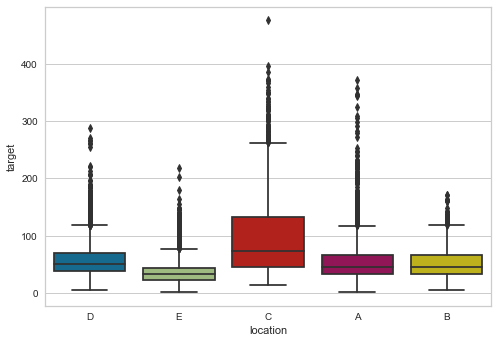

In [31]:
sns.boxplot(y='target',x='location', data=data);

The location makes quite a big difference on the target.

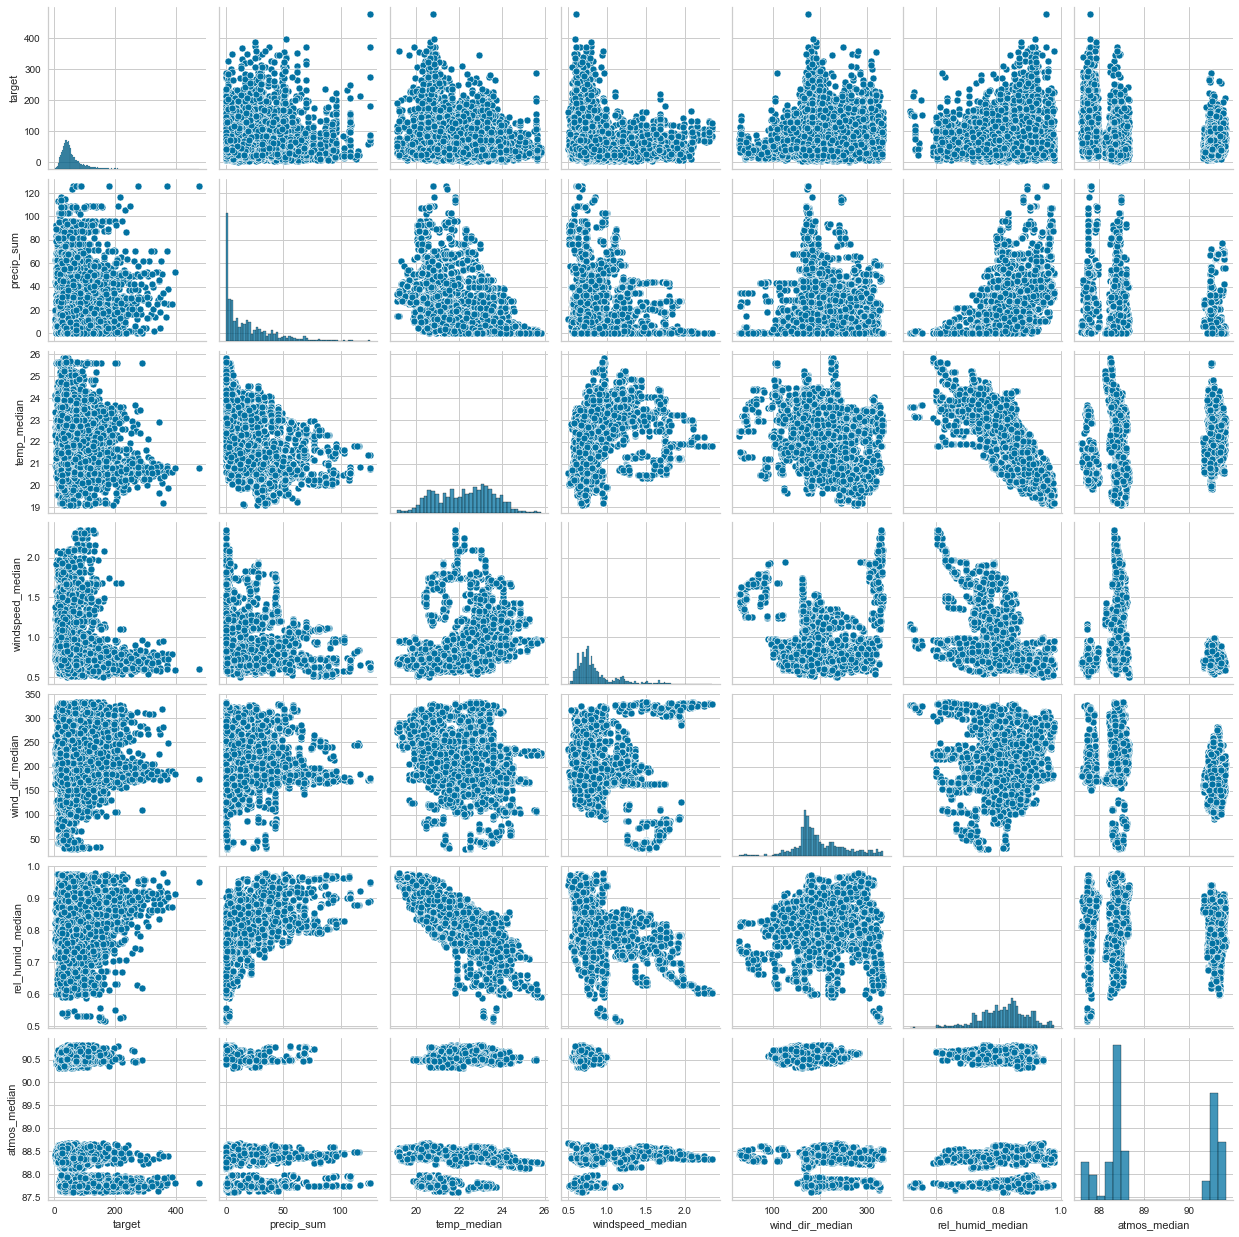

In [32]:
sns.pairplot(data_agg[['target','precip_sum','temp_median','windspeed_median','wind_dir_median','rel_humid_median',
                    'atmos_median']])

<AxesSubplot:>

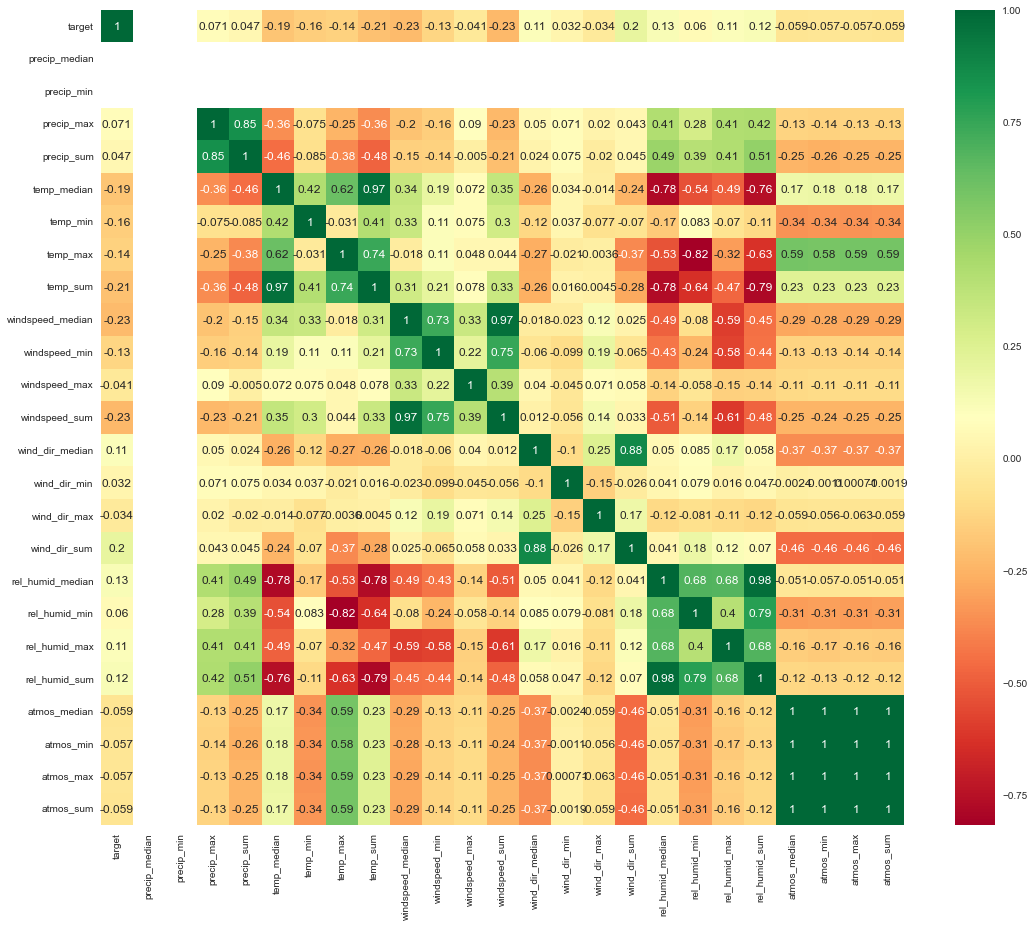

In [33]:
plt.figure(figsize = (18,15))
sns.heatmap(data_agg.corr(), annot = True, cmap = 'RdYlGn')

The target is not highly correlated with any of the features.

Here we can see a correlation between the temperature and the relative humidity, which makes sense. By calculating the dew point we can remove the correlation and have 2 independent features.

Wind direction is also tricky. In the dataset the wind direction is given in degree which range from 0 to 360 but 0 and 360 would be the same. by changing them into north/south and east/west directions we can change that.

---

## __Defining target and Train-Test-Split__

In [34]:
X = data.drop(['target', 'ID'], axis = 1)
y = data.target

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = X.location, test_size = 0.2, random_state = 42)

In [36]:
print('y Train:', y_train.shape)
print('y Test:', y_test.shape)
print('X Train:', X_train.shape)
print('X Test:', X_test.shape)

y Train: (10327,)
y Test: (2582,)
X Train: (10327, 727)
X Test: (2582, 727)


---

## __Baseline model__

The EDA showed that the location has a large influence on the target, thus the baseline model is only based on the mean PM2.5 value by location.

We defined the predicted values to calculate the RMSE with y_test and the predicted y_test.

In [37]:
target_loc = data.groupby('location').mean()['target']
target_loc.head()

location
A    56.313447
B    53.027247
C    98.658320
D    58.837273
E    37.229190
Name: target, dtype: float64

In [38]:
X_test_pred = pd.merge(X_test,target_loc,on='location')
y_test_pred = X_test_pred['target']

In [39]:
sqrt(mean_squared_error(y_test, y_test_pred))

46.22994743427673

The baseline model has a RMSE of 46.

---

## __Target transformation__

To know how our target in the train and test dataset is distributed and if it is normal distribution we plotted with histograms.

<AxesSubplot:xlabel='target', ylabel='Count'>

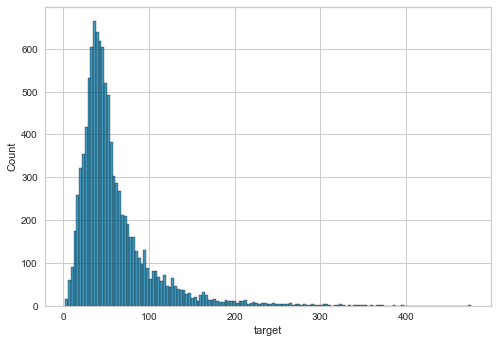

In [40]:
sns.histplot(y_train)

<AxesSubplot:xlabel='target', ylabel='Count'>

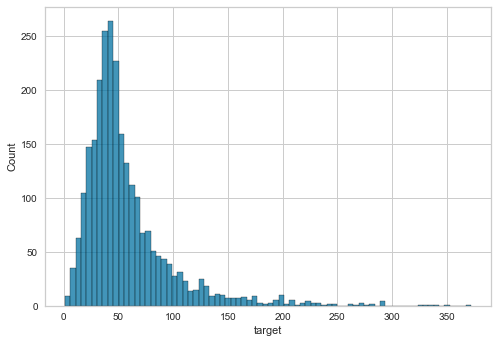

In [41]:
sns.histplot(y_test)

As we can see in the last two plots, the target variable is not normally distributed. 
Therefore we needed a log transform for both.

<AxesSubplot:xlabel='target', ylabel='Count'>

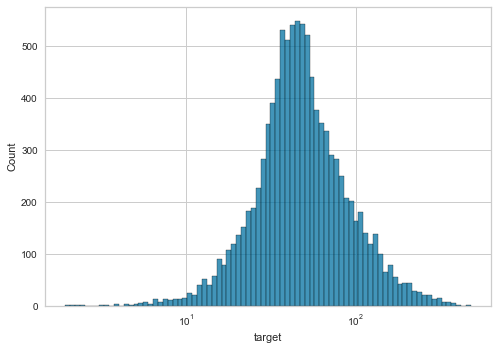

In [42]:
sns.histplot(y_train,log_scale=True)


<AxesSubplot:xlabel='target', ylabel='Count'>

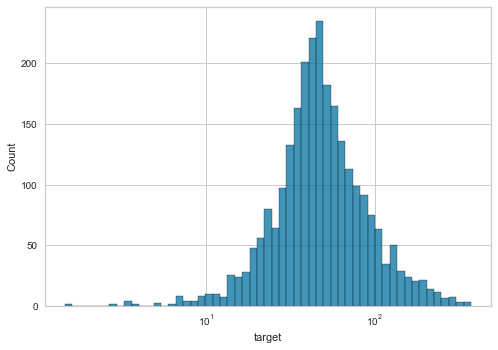

In [43]:
sns.histplot(y_test,log_scale=True)

There are still some small value outliers, but the distribution is closer to being normally distributed. 

In [44]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

---

## __Feature Engineering__

As we saw above, the feature location has to be changed into dummy variables to be used in a model.

In [45]:
X_train = pd.get_dummies(X_train, drop_first=True, columns= ['location'])
X_test = pd.get_dummies(X_test, drop_first=True, columns= ['location'])
print('X Train:', X_train.shape)
print('X Test:', X_test.shape)

X Train: (10327, 730)
X Test: (2582, 730)


The meteorological data contains the relative humidity as parameter. Relative humidity depends on the temperature as warm air can store more water vapor than cold air. We will convert this parameter to a temperature independent measure for humidity, the dew point. The dew point is the temperature at which the air is saturated with water vapor.

Information about wind are given as wind speed and wind direction in the original data. These parameter are easy to interpret, however having difficulties when it comes to modelling. The wind direction is given as degrees North from 0 to 360, that means 1°N and 359°N are close together, but cannot be interpreted like this in a model. Therefore, wind speed and wind direction are converted to wind components in North-South and East-West direction.

For the conversion of the meteorological parameters the Python library [MetPy](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.html) is used. Beside a collection of meteorologically significant constants, it offers a module to provide unit support (based on [pint](https://pint.readthedocs.io/en/stable/developers_reference.html#module-pint)) and tools for unit-aware, meteorological calculations.

In [46]:
#add the new column dew point

X_train = X_train.reset_index()
for i in range(121):
    col_temp = 'newtemp'+str(i)
    temperature = np.array(X_train[col_temp])*units.degC
    col_humidity = 'newrel_humidity'+str(i)
    humidity = np.array(X_train[col_humidity])*100*units.percent
    dew_point = mpcalc.dewpoint_from_relative_humidity(temperature,humidity)
    col_dew_point = 'dew_point'+str(i)
    df_dew_point = pd.DataFrame(dew_point.magnitude, columns =[col_dew_point])
    col_windspeed = 'windspeed'+str(i)
    windspeed = np.array(X_train[col_windspeed])*units.meter_per_second
    col_wind_dir = 'newwind_dir'+str(i)
    wind_dir = np.array(X_train[col_wind_dir])*units.degree_N
    windvectors = mpcalc.wind_components(windspeed,wind_dir)
    wind_WE = windvectors[0]
    wind_NS = windvectors[1]
    col_wind_WE = 'wind_WE_'+str(i)
    col_wind_NS = 'wind_NS_'+str(i)
    df_wind_WE = pd.DataFrame(wind_WE.magnitude, columns =[col_wind_WE])
    df_wind_NS = pd.DataFrame(wind_NS.magnitude, columns =[col_wind_NS])
    X_train = pd.concat([X_train,df_dew_point,df_wind_WE,df_wind_NS],axis=1)

In [47]:
X_train

,index,newprecip0,newprecip1,newprecip2,newprecip3,newprecip4,newprecip5,newprecip6,newprecip7,newprecip8,...,wind_NS_117,dew_point118,wind_WE_118,wind_NS_118,dew_point119,wind_WE_119,wind_NS_119,dew_point120,wind_WE_120,wind_NS_120
0,7127,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.000,0.0,...,1.195925,19.165053,-0.564565,0.469326,18.642414,-0.363543,0.129242,18.414536,0.049851,-0.414513
1,4532,0.000,0.000,0.0,0.0,0.0,0.000,0.017,0.017,0.0,...,0.207734,18.923940,0.321499,-0.450351,18.358260,0.650297,-0.460208,18.291040,-0.164121,-0.901008
2,4751,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.000,0.0,...,-0.179632,17.209697,0.809048,-0.179632,17.209697,0.809048,-0.179632,17.209697,0.809048,-0.179632
3,9390,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.000,0.0,...,-0.563072,16.828082,0.377743,-0.281059,16.971942,0.181403,-0.355566,19.780937,0.633691,-0.128894
4,12191,0.000,0.000,0.0,0.0,0.0,0.017,0.000,0.000,0.0,...,-0.416910,17.023118,0.523643,0.047947,17.005337,0.113185,-0.470751,16.931272,-0.330666,-0.133682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10322,7147,0.017,0.017,0.0,0.0,0.0,0.000,0.000,0.000,0.0,...,0.741594,18.847753,0.254865,0.741594,18.683108,0.254865,0.741594,15.040754,0.254865,0.741594
10323,3880,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.000,0.0,...,-1.694160,13.270042,0.002665,-1.700907,13.149927,0.837956,-1.820581,12.737967,0.445087,-1.360723
10324,6261,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.000,0.0,...,0.776438,19.763682,-1.273956,0.564281,19.144909,-0.677223,0.826260,20.023433,-1.631183,1.023756
10325,8133,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.000,0.0,...,-0.176346,18.239632,-0.288866,-0.393734,18.551861,-0.004358,-0.450812,18.888746,0.504387,-0.170732


In [48]:
X_test

,newprecip0,newprecip1,newprecip2,newprecip3,newprecip4,newprecip5,newprecip6,newprecip7,newprecip8,newprecip9,...,atmospherepressure115,atmospherepressure116,atmospherepressure117,atmospherepressure118,atmospherepressure119,atmospherepressure120,location_B,location_C,location_D,location_E
14334,0.000,0.000,0.000,0.000,0.221,0.408,0.000,0.000,0.0,0.000,...,90.801667,90.766667,90.672500,90.582500,90.485833,90.392500,0,0,1,0
5165,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,...,88.275000,88.318333,88.353333,88.361667,88.414167,88.468333,0,0,0,0
653,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,...,90.335000,90.324167,90.410000,90.600833,90.590833,90.549167,0,0,1,0
11882,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,...,88.648333,88.617500,88.582500,88.510000,88.378333,88.355000,0,0,0,0
15512,0.085,0.119,0.017,0.000,0.000,0.204,0.153,0.000,0.0,0.000,...,88.578333,88.578333,88.578333,88.578333,88.578333,88.578333,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,...,90.751667,90.797500,90.788333,90.715833,90.633333,90.534167,0,0,1,0
15025,0.000,0.000,0.000,0.000,0.000,0.000,0.000,8.944,0.0,0.000,...,88.390000,88.400000,88.431667,88.470000,88.520000,88.560000,0,0,0,0
11553,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,...,90.334167,90.379167,90.418182,90.458333,90.543333,90.591818,0,0,1,0
691,0.119,0.085,0.017,0.697,0.051,0.017,0.017,0.000,0.0,0.017,...,90.847500,90.783333,90.705833,90.592500,90.485000,90.434167,0,0,1,0


In [49]:
X_test = X_test.reset_index()
for i in range(121):
    col_temp = 'newtemp'+str(i)
    temperature = np.array(X_test[col_temp])*units.degC
    col_humidity = 'newrel_humidity'+str(i)
    humidity = np.array(X_test[col_humidity])*100*units.percent
    dew_point = mpcalc.dewpoint_from_relative_humidity(temperature,humidity)
    col_dew_point = 'dew_point'+str(i)
    df_dew_point = pd.DataFrame(dew_point.magnitude, columns =[col_dew_point])
    col_windspeed = 'windspeed'+str(i)
    windspeed = np.array(X_test[col_windspeed])*units.meter_per_second
    col_wind_dir = 'newwind_dir'+str(i)
    wind_dir = np.array(X_test[col_wind_dir])*units.degree_N
    windvectors = mpcalc.wind_components(windspeed,wind_dir)
    wind_WE = windvectors[0]
    wind_NS = windvectors[1]
    col_wind_WE = 'wind_WE_'+str(i)
    col_wind_NS = 'wind_NS_'+str(i)
    df_wind_WE = pd.DataFrame(wind_WE.magnitude, columns =[col_wind_WE])
    df_wind_NS = pd.DataFrame(wind_NS.magnitude, columns =[col_wind_NS])
    X_test = pd.concat([X_test,df_dew_point,df_wind_WE,df_wind_NS],axis=1)

In [50]:
X_test

,index,newprecip0,newprecip1,newprecip2,newprecip3,newprecip4,newprecip5,newprecip6,newprecip7,newprecip8,...,wind_NS_117,dew_point118,wind_WE_118,wind_NS_118,dew_point119,wind_WE_119,wind_NS_119,dew_point120,wind_WE_120,wind_NS_120
0,14334,0.000,0.000,0.000,0.000,0.221,0.408,0.000,0.000,0.0,...,0.809649,19.793851,-0.315006,1.226872,19.530470,0.076962,1.012078,26.984285,-0.410034,0.725477
1,5165,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,...,0.161912,18.008889,-0.102002,-0.446839,17.952921,0.401287,0.285525,18.102074,0.423095,0.427778
2,653,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,...,-0.584970,19.020787,-0.392912,0.678148,18.159358,-0.392912,0.678148,18.616968,-0.392912,0.678148
3,11882,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,...,0.403718,19.692107,0.631575,0.403718,19.748384,0.631575,0.403718,19.966832,0.631575,0.403718
4,15512,0.085,0.119,0.017,0.000,0.000,0.204,0.153,0.000,0.0,...,0.520876,19.455209,0.300317,0.520876,19.455209,0.300317,0.520876,19.455209,0.300317,0.520876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2577,1609,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,...,0.103889,19.820474,-0.476384,0.607065,20.121610,-0.320422,0.906715,19.645221,-0.226976,0.901877
2578,15025,0.000,0.000,0.000,0.000,0.000,0.000,0.000,8.944,0.0,...,-0.169868,18.384806,0.918592,-0.169868,19.520056,0.918592,-0.169868,19.905833,0.918592,-0.169868
2579,11553,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,...,0.021677,18.702689,0.285232,0.427797,18.370186,0.453360,-0.110644,17.861945,0.486346,0.042294
2580,691,0.119,0.085,0.017,0.697,0.051,0.017,0.017,0.000,0.0,...,0.040336,21.348518,-0.214771,0.769767,21.444395,-0.212779,0.954914,21.041409,0.236572,0.832887


In [51]:
#drop the column index and create 2 new variables 

cols_drop = ['index']
for i in range(121):
    cols_drop.append('newrel_humidity'+str(i))
    cols_drop.append('newwind_dir'+str(i))
    cols_drop.append('windspeed'+str(i))

X_train_met = X_train.drop(cols_drop, axis = 1)
X_test_met = X_test.drop(cols_drop, axis = 1)

In [52]:
X_train_met

,newprecip0,newprecip1,newprecip2,newprecip3,newprecip4,newprecip5,newprecip6,newprecip7,newprecip8,newprecip9,...,wind_NS_117,dew_point118,wind_WE_118,wind_NS_118,dew_point119,wind_WE_119,wind_NS_119,dew_point120,wind_WE_120,wind_NS_120
0,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,...,1.195925,19.165053,-0.564565,0.469326,18.642414,-0.363543,0.129242,18.414536,0.049851,-0.414513
1,0.000,0.000,0.0,0.0,0.0,0.000,0.017,0.017,0.0,0.0,...,0.207734,18.923940,0.321499,-0.450351,18.358260,0.650297,-0.460208,18.291040,-0.164121,-0.901008
2,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,...,-0.179632,17.209697,0.809048,-0.179632,17.209697,0.809048,-0.179632,17.209697,0.809048,-0.179632
3,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,...,-0.563072,16.828082,0.377743,-0.281059,16.971942,0.181403,-0.355566,19.780937,0.633691,-0.128894
4,0.000,0.000,0.0,0.0,0.0,0.017,0.000,0.000,0.0,0.0,...,-0.416910,17.023118,0.523643,0.047947,17.005337,0.113185,-0.470751,16.931272,-0.330666,-0.133682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10322,0.017,0.017,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,...,0.741594,18.847753,0.254865,0.741594,18.683108,0.254865,0.741594,15.040754,0.254865,0.741594
10323,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,...,-1.694160,13.270042,0.002665,-1.700907,13.149927,0.837956,-1.820581,12.737967,0.445087,-1.360723
10324,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,...,0.776438,19.763682,-1.273956,0.564281,19.144909,-0.677223,0.826260,20.023433,-1.631183,1.023756
10325,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,...,-0.176346,18.239632,-0.288866,-0.393734,18.551861,-0.004358,-0.450812,18.888746,0.504387,-0.170732


In [53]:
X_test_met

,newprecip0,newprecip1,newprecip2,newprecip3,newprecip4,newprecip5,newprecip6,newprecip7,newprecip8,newprecip9,...,wind_NS_117,dew_point118,wind_WE_118,wind_NS_118,dew_point119,wind_WE_119,wind_NS_119,dew_point120,wind_WE_120,wind_NS_120
0,0.000,0.000,0.000,0.000,0.221,0.408,0.000,0.000,0.0,0.000,...,0.809649,19.793851,-0.315006,1.226872,19.530470,0.076962,1.012078,26.984285,-0.410034,0.725477
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,...,0.161912,18.008889,-0.102002,-0.446839,17.952921,0.401287,0.285525,18.102074,0.423095,0.427778
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,...,-0.584970,19.020787,-0.392912,0.678148,18.159358,-0.392912,0.678148,18.616968,-0.392912,0.678148
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,...,0.403718,19.692107,0.631575,0.403718,19.748384,0.631575,0.403718,19.966832,0.631575,0.403718
4,0.085,0.119,0.017,0.000,0.000,0.204,0.153,0.000,0.0,0.000,...,0.520876,19.455209,0.300317,0.520876,19.455209,0.300317,0.520876,19.455209,0.300317,0.520876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2577,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,...,0.103889,19.820474,-0.476384,0.607065,20.121610,-0.320422,0.906715,19.645221,-0.226976,0.901877
2578,0.000,0.000,0.000,0.000,0.000,0.000,0.000,8.944,0.0,0.000,...,-0.169868,18.384806,0.918592,-0.169868,19.520056,0.918592,-0.169868,19.905833,0.918592,-0.169868
2579,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,...,0.021677,18.702689,0.285232,0.427797,18.370186,0.453360,-0.110644,17.861945,0.486346,0.042294
2580,0.119,0.085,0.017,0.697,0.051,0.017,0.017,0.000,0.0,0.017,...,0.040336,21.348518,-0.214771,0.769767,21.444395,-0.212779,0.954914,21.041409,0.236572,0.832887


---

## __KNN model__

With first tests KNN could be identified as the most promising model. Comparing Standard Scaler and Min-Max-Scaler, there were slightly better results with Min-Max-Scaler. The best hyper parameter were identified by Grid Search. In order to avoid overfitting, distance weights are not used.

In [54]:
#create a pipeline

pip = make_pipeline(MinMaxScaler(), 
        KNeighborsRegressor(n_neighbors=5, metric='minkowski', p=1, weights='uniform', leaf_size=20, n_jobs=-1))

In [55]:
pip.fit(X_train, np.ravel(y_train_log))

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('kneighborsregressor',
                 KNeighborsRegressor(leaf_size=20, n_jobs=-1, p=1))])

In [56]:
y_pred_test = pip.predict(X_test)
y_pred_train = pip.predict(X_train)

In [57]:
y_pred_test_unlog = np.exp(y_pred_test)
y_pred_train_unlog = np.exp(y_pred_train)

In [58]:
print('RMSE Test unlog:', sqrt(mean_squared_error(y_train, y_pred_train_unlog)))
print('RMSE Train unlog:', sqrt(mean_squared_error(y_test, y_pred_test_unlog)))

RMSE Test unlog: 21.694248374356313
RMSE Train unlog: 25.508594605757814


---

## __Error analysis__

We used the visualizer to plot the residuals: Green for the test data, blue for the train data.
The two plots visualizes the values before and after the log transform.

/Users/rweil/neue_fische/project2_air_quality/.venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


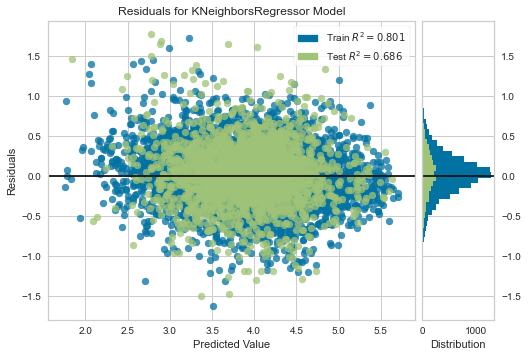

<AxesSubplot:title={'center':'Residuals for KNeighborsRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [59]:
visualizer = ResidualsPlot(pip)

visualizer.fit(X_train, y_train_log)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test_log)  # Evaluate the model on the test data
visualizer.show()  

In the residual plot we can see, that we are underpredicting the low values by a bit and overpredicting the higher values by a bit as well.

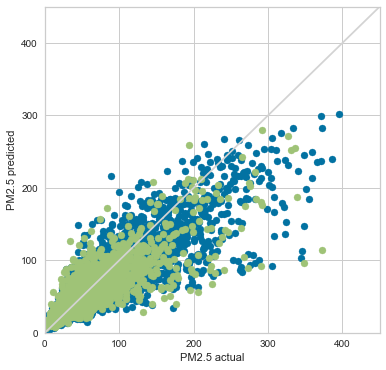

In [60]:
fig=plt.figure(figsize=(6, 6))
plt.axline([1, 1], [2, 2],color='lightgrey')
plt.scatter(y_train,y_pred_train_unlog)
plt.scatter(y_test, y_pred_test_unlog)
plt.xticks(np.arange(0,501,100));
plt.yticks(np.arange(0,501,100));
plt.xlabel("PM2.5 actual");
plt.ylabel("PM2.5 predicted");
plt.xlim(0, 450);
plt.ylim(0, 450);

Here it is more obvious, that we over predicted the higher values.

---

## __Convert prediction to warning__

To increase awareness against air pollution and maybe include our prediction in a weather forecast, we have to present the danger in an easy accessible way. Therefore we transform our prediction in warning levels that are easy to understand: No warning, Prewarning, Warning.

After converting the target values we created a confusion matrix we also used in the presentation for the stakeholder __(see the PDF in our repository)__.

In [61]:
def convert_to_warning(y):
    y_class = []
    for i in y:
        if i <= 35:
            y_class.append('no_warning')
        elif i <= 55:
            y_class.append('prewarning')
        else:
            y_class.append('warning')
    return y_class

In [62]:
y_warning_train = convert_to_warning(y_train)
y_warning_train_pred = convert_to_warning(y_pred_train_unlog)
y_warning_test = convert_to_warning(y_test)
y_warning_test_pred = convert_to_warning(y_pred_test_unlog)

In [63]:
cm_warning_train = confusion_matrix(y_warning_train,y_warning_train_pred)
cm_warning_test = confusion_matrix(y_warning_test,y_warning_test_pred)
PM_warnings = ['no_warning','prewarning','warning']

In [64]:
def plot_confusion_matrix(cm,classes):
        # Plot the confusion matrix
        plt.figure(figsize = (10, 10))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Oranges)
        plt.title('Confusion matrix', size = 24)
        plt.colorbar(aspect=4)
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45, size = 14)
        plt.yticks(tick_marks, classes, size = 14)

        fmt = 'd'
        thresh = cm.max() / 2.
    
        # Labeling the plot
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                plt.text(j, i, format(cm[i, j], fmt), fontsize = 20, horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
        
        plt.grid(None)
        plt.tight_layout()
        plt.ylabel('True label', size = 18)
        plt.xlabel('Predicted label', size = 18)

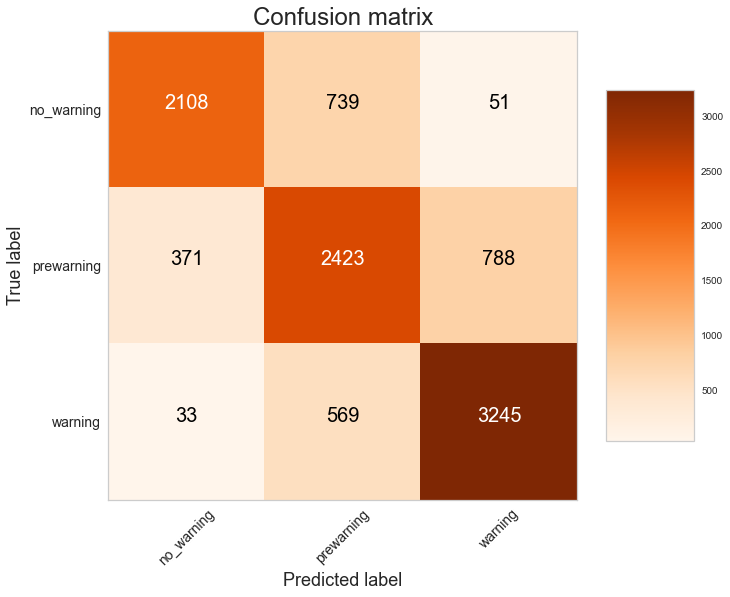

In [65]:
plot_confusion_matrix(cm_warning_train,PM_warnings)

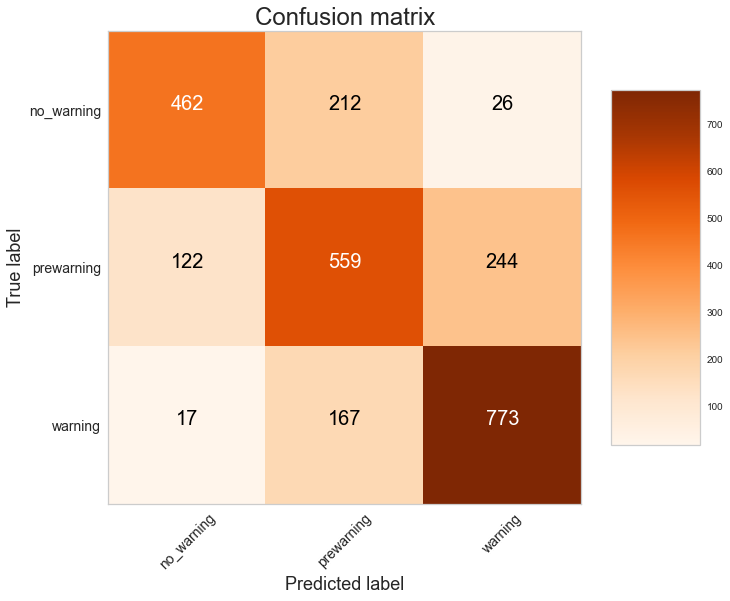

In [66]:
plot_confusion_matrix(cm_warning_test,PM_warnings)

---

## __Forecast__

As you can see, there are still misclassifications. To improve the strength of our prediction we need more than the data from 5 stations only and it is mandatory to include data about especially distances to motorways and roads, peak traffic times, operating industry (direction, nature), number of households in the proximity and exact assigned to day time and seasons (rainy and dry season).

![image map](images/ML_project-forecast.png)

![image map](https://github.com/r-weil/project2_air_quality/blob/main/images/ML_project-forecast_matrix.png)